# Mini Reto 006 del grupo Python para Trading

# Backtrader - Estrategia basada en cruce de medias moviles simples (SMA) 


Este mini reto es la continuación natural del Mini Reto 005 donde se calcularon las medias móviles rápidas y lentas para identificar los cruces y generar una señal a partir de dichos cruces.

En esta ocasión, lo que se pide es utilizar esa experiencia previa para montar una estrategia y hacer el backtesting para evaluar los resultados de la estrategia con datos de muestra.

Lo mas sencillo, que no lo más optimo ni "real", es hacer un backtest vectorizado, dónde se añaden columnas a cada periodo indicando el beneficio/perdida en ese periodo y finalmente obtener el acumulado para saber si ha habido o no beneficio. 

Esto ya se muestra en detalle en el siguiente Webinar ( https://www.youtube.com/watch?v=CNCRGcFh5Lo ), así que vamos a dar el siguiente paso utilizando `Backtrader` para simular la estrategia lo mas "real" posible. 

Partiendo del código que hay a continuación:

- 1) Diseñar la estrategia en base a los indicadores
- 2) Configurar el entorno de backtrader
- 3) Ejecutar el backtesting con la estrategia
- 4) Analizar los resultados


**Se pide** COMPLETAR el punto 1 para hacer funcionar el Notebook al completo.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import backtrader as bt
import pyfolio as pf

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[12, 8]
%config InlineBackend.figure_format = 'retina'


import yfinance as yf
from math import floor

## Estrategia de cruce de medias con porcentaje de exposición


En esta estrategia pretendendemos siempre estar expuestos, tendremos una posición abierta siempre, larga o corta en función del último cruce.

Además en vez de fijar un número fijo de acciones, queremos establecer nuestra posición como un porcentaje dado del valor de nuestra cartera. Esto permite reinvertir los beneficios, tendríamos un interés compuesto.

Para ello vamos a definir un `sizer` es decir una [clase de Backtrader](https://www.backtrader.com/docu/sizers/sizers/) que permite calcular el tamaño de cada orden en base a una seríe de parametros que definimos. En este caso en base al porcentaje definido, el valor de la cartera y el precio del activo en el momento del cruce.

In [2]:
# Clase heredada de bt.Sizer al que le pasamos el porcentaje 
# que queremos estar expuestos

class PercentValue(bt.Sizer):
    params = (('percent', .90),)

    def _getsizing(self, comminfo, cash, data, isbuy):
        # Calculamos la posición diviendo el porcentaje deseado 
        # del valor de la cartera entre el precio del activo
        return floor((self.broker.get_value() * self.params.percent / data) )

In [3]:
# Descargamos los datos

aapl = yf.download('AAPL', '2020-1-1','2020-10-25')

[*********************100%***********************]  1 of 1 completed


In [4]:
## Diseñamos la estrategia

class cruceSMA_(bt.Strategy):
    params = dict(slow=14,
                  fast=60
                 )

    def __init__(self):
        fast = bt.ind.SMA(period=self.p.fast)
        slow = bt.ind.SMA(period=self.p.slow)
        self.crossover = bt.ind.CrossOver(fast, slow)

    def next(self):
        
        
        if self.crossover != 0 and self.position:  # Si hay una operacion abierta y ocurre cruce 
            self.close()                          # cerramos la posición, para después abrir contraria
        if self.crossover == 1: # si la rapida cruza hacia arriba la lenta
            self.buy()         # Se entra en LONG
        if self.crossover == -1: # si la rapida cruza hacia abajo la lenta
            self.sell()        # Se entra en SHORT

In [5]:
## Definimos los parametros de la estrategia

fast_SMA = 9
slow_SMA = 30
cash = 1000
exposure=.90


## Configuramos el entorno

cerebro = bt.Cerebro()
cerebro.broker.set_cash(cash)

data = bt.feeds.PandasData(dataname=aapl)
cerebro.adddata(data)

cerebro.addstrategy(cruceSMA_, slow=slow_SMA, fast=fast_SMA) # Determinamos la estrategia
cerebro.addsizer(PercentValue, percent=exposure)  # Añadimos el sizer
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')  # Añadimos el analizador


## Ejecutamos el backtesting

results = cerebro.run()

<IPython.core.display.Javascript object>


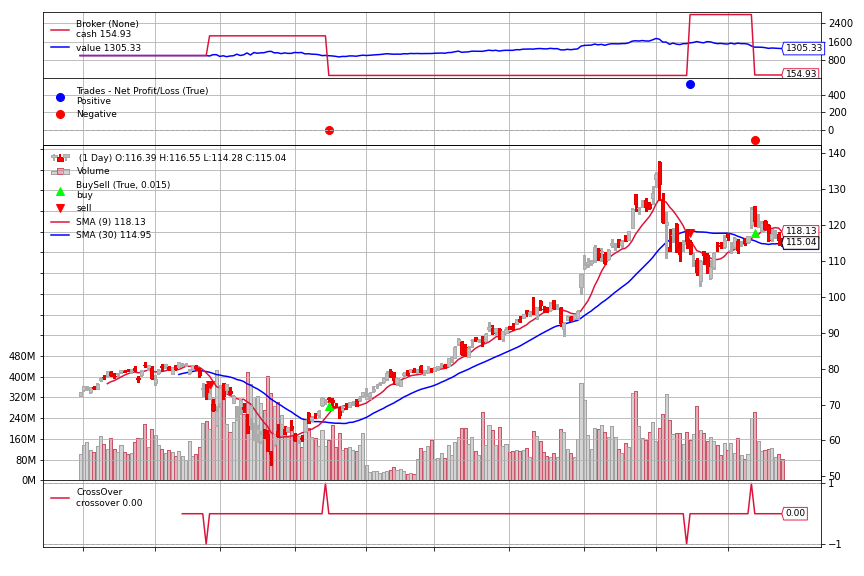

[[<Figure size 864x576 with 5 Axes>]]

In [6]:
## Graficamos el resultado del backtest

cerebro.plot(style='candlebar')

## Analizamos los resultados

In [9]:
# Definimos una función para visualizar los resultados del análisis pyfolio
def analisis(results, strategy_id=0):
    pyfolio_analyzer = results[strategy_id].analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
    %matplotlib inline
    return pf.create_full_tear_sheet(returns, transactions=transactions, positions=positions)

Start date,2019-12-31
End date,2020-10-23
Total months,9
,Backtest
Annual return,38.317%
Cumulative returns,30.533%
Annual volatility,38.488%
Sharpe ratio,1.03
Calmar ratio,1.52
Stability,0.79
Max drawdown,-25.216%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.22,2020-09-01,2020-10-23,NaT,NaN
1,20.74,2020-03-23,2020-04-21,2020-06-10,58
2,8.48,2020-02-28,2020-03-04,2020-03-09,7
3,8.00,2020-03-12,2020-03-13,2020-03-16,3
4,5.42,2020-03-09,2020-03-10,2020-03-12,4


Top 10 long positions of all time,max
Data0,92.25%


Top 10 short positions of all time,max
Data0,-96.56%


Top 10 positions of all time,max
Data0,96.56%


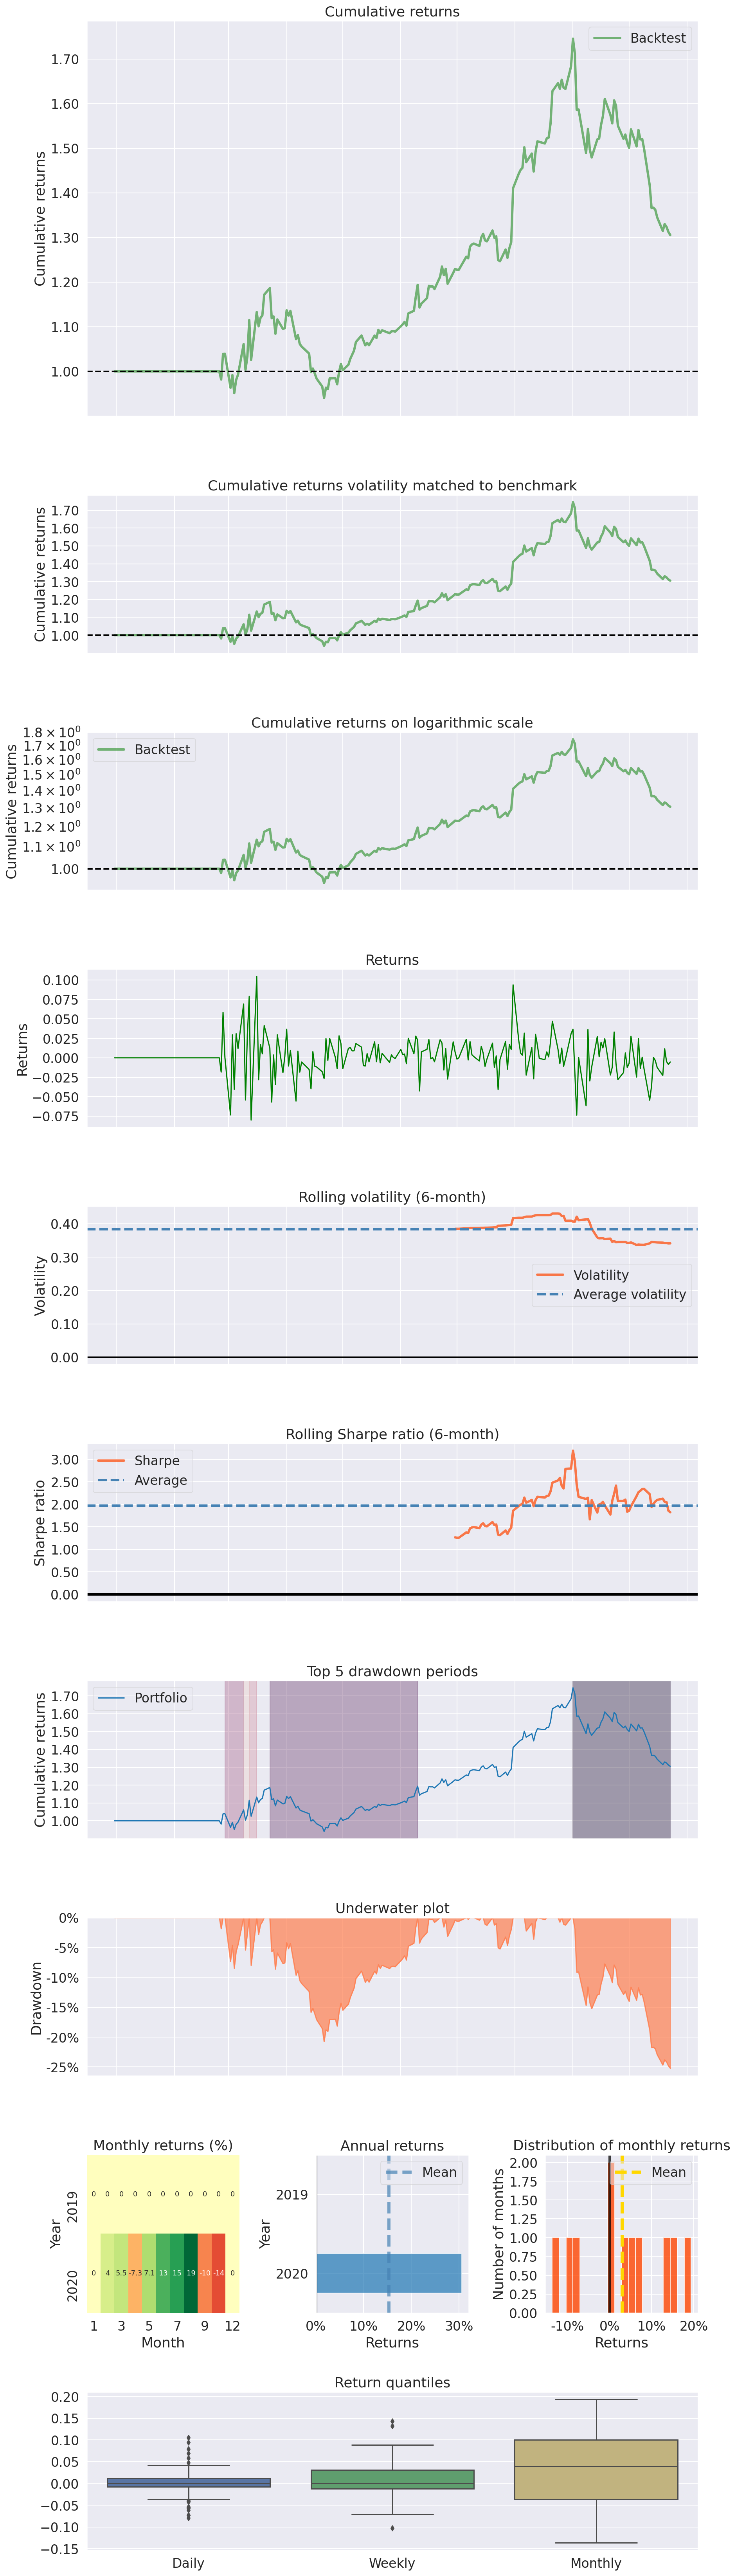

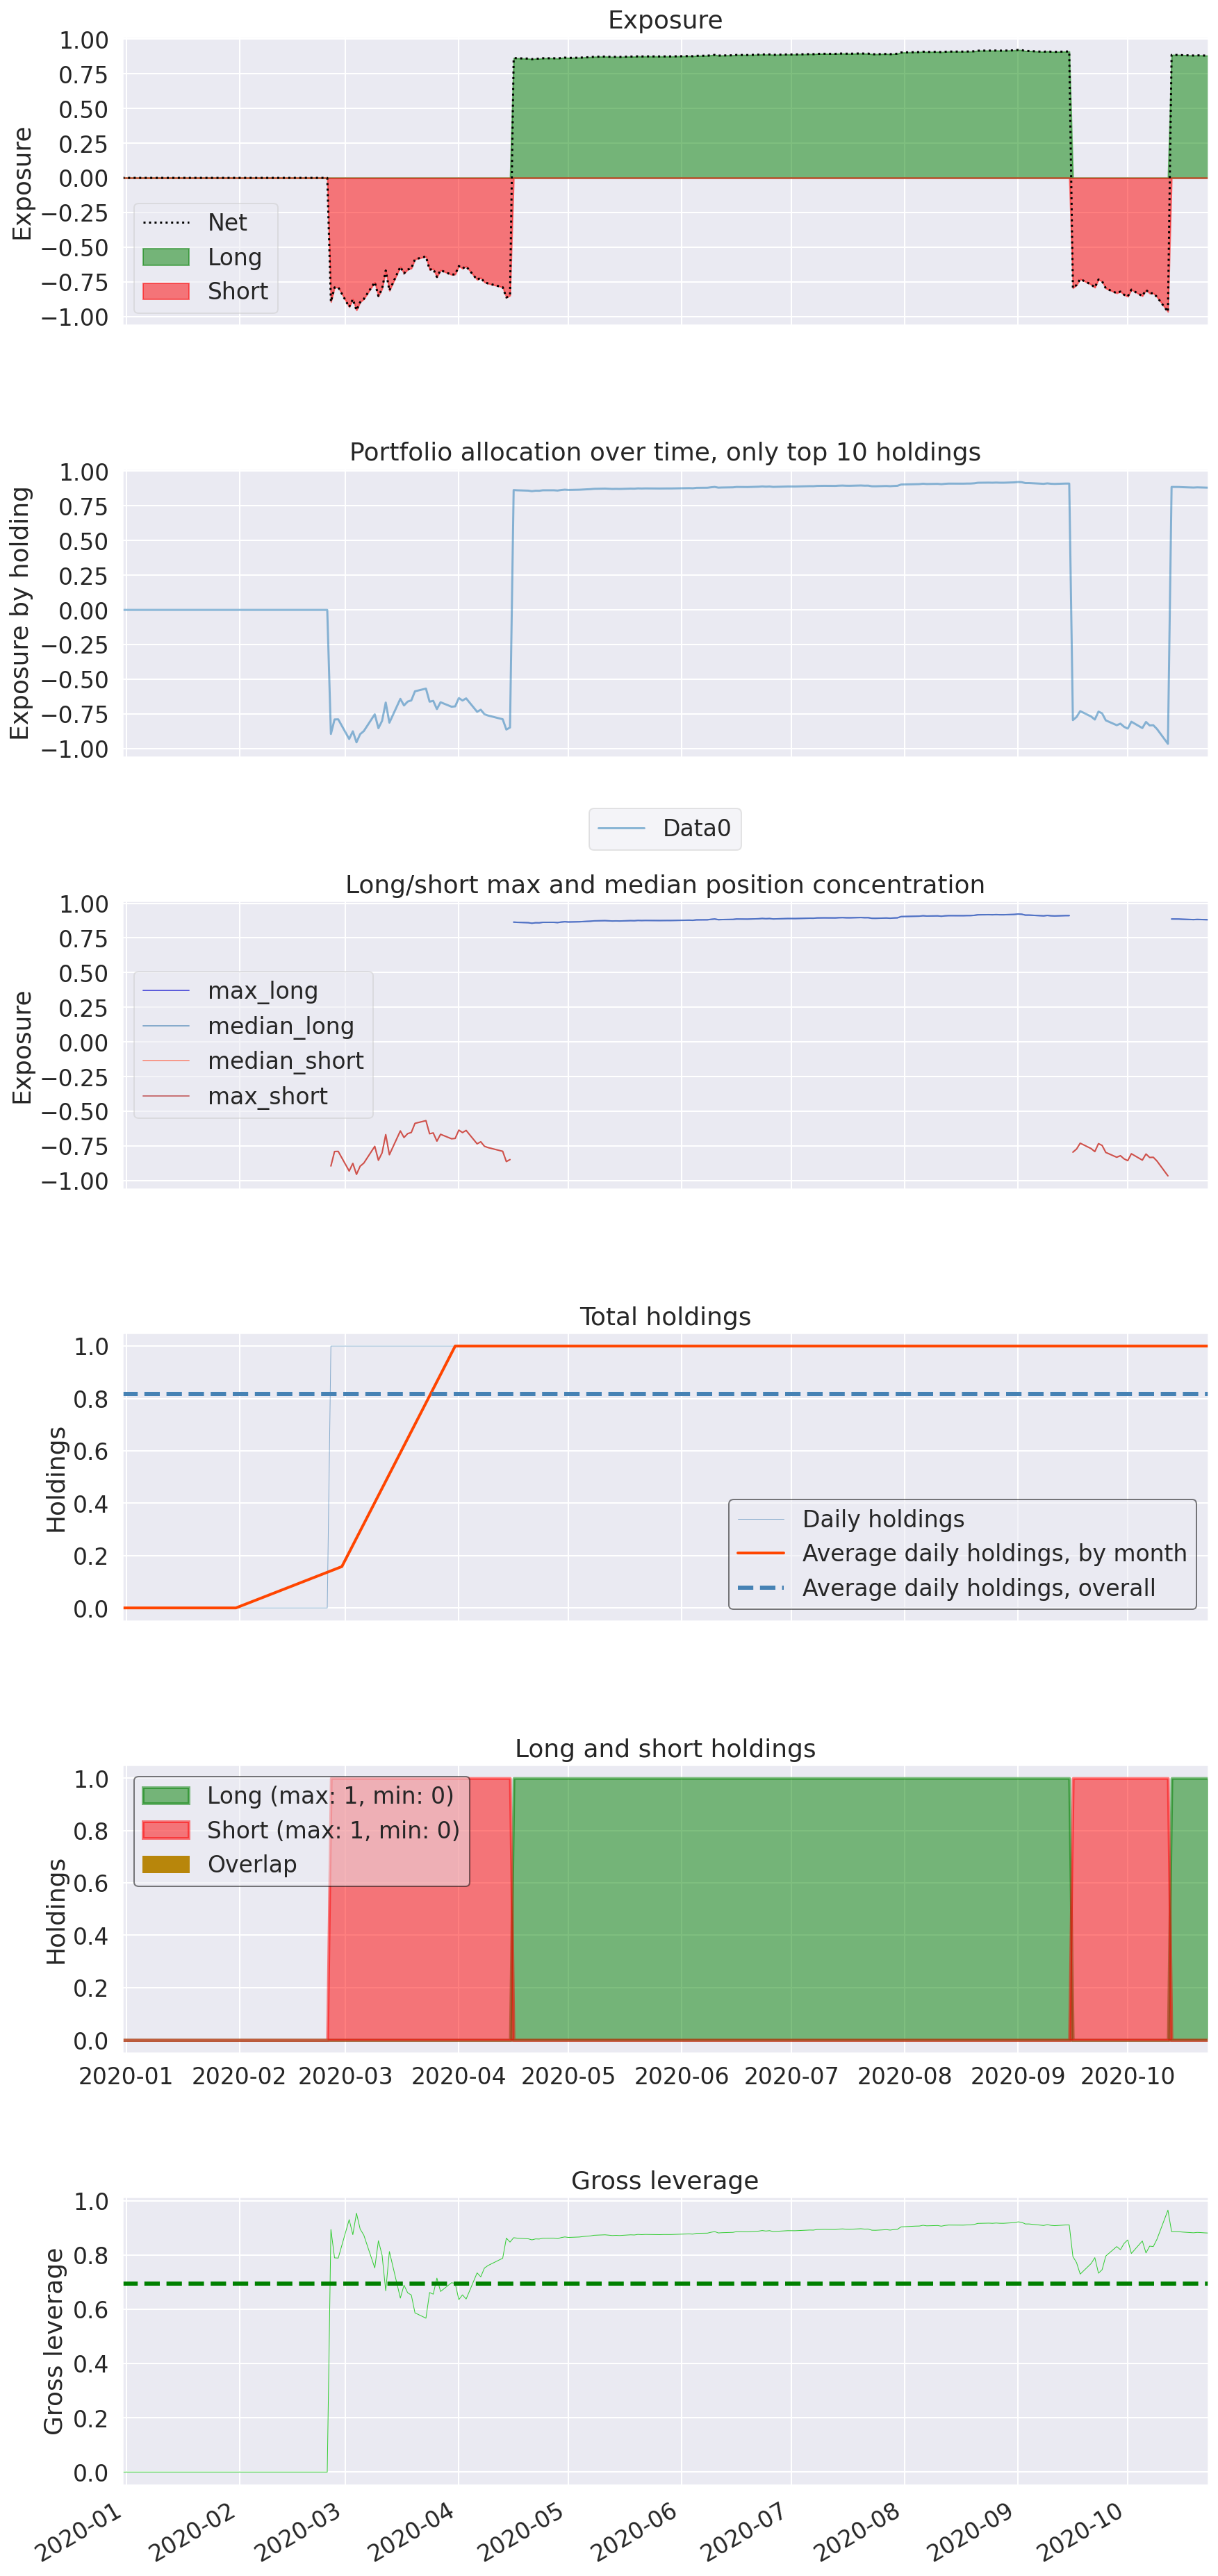

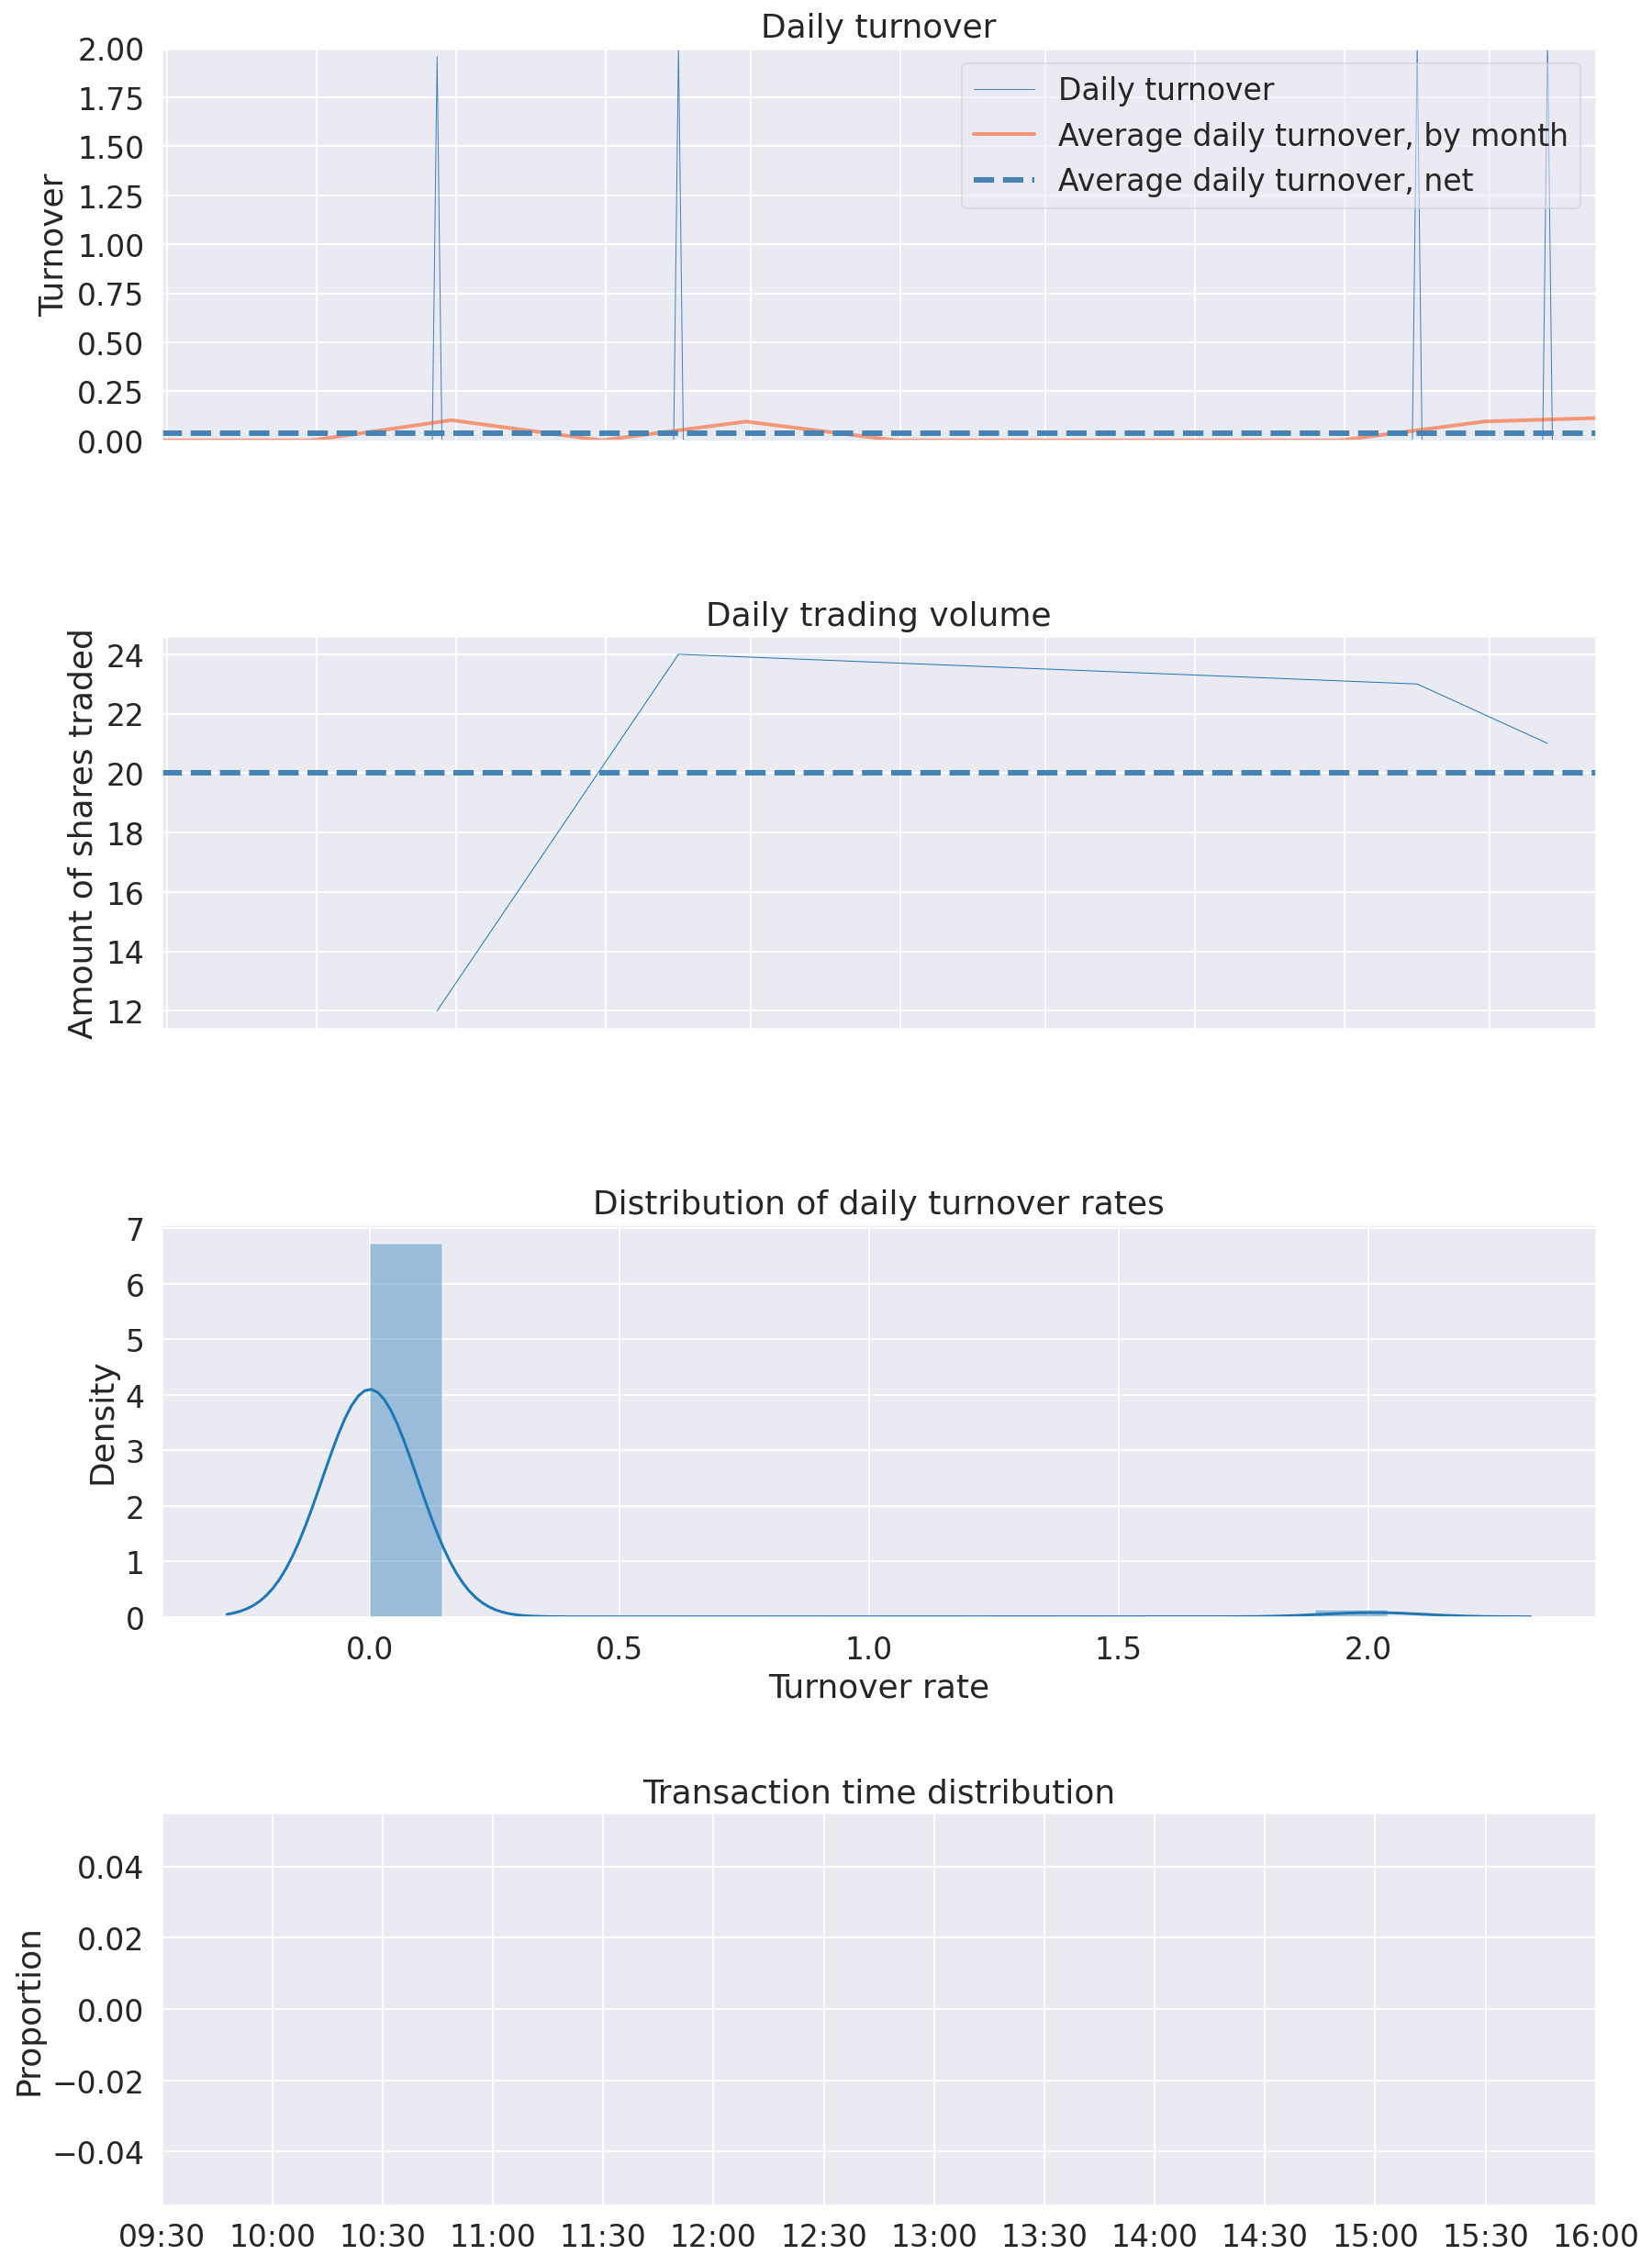

In [10]:
# Visualizamos el análisis
analisis(results)